In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential, Model
from keras.layers import Conv1D, Dense, Dropout, Input, MaxPooling1D, Flatten
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import utils

utils.set_random_seed(42)

In [ ]:
# Define Parameters
LOOKBACK = 24
HORIZON = 24
N_SPLITS = 4
BATCH_SIZE = 64
EPOCHS = 20
model_name = 'cnn_multi2'

# Prepare data

In [ ]:
imp_folder = os.getenv("DATA_PATH", "./default_data_path/")
exp_folder = os.getenv("MODEL_PATH", "./default_model_path/")

df = pd.read_csv(imp_folder + 'cell_multivar.csv')

print(df.shape)
df.columns

(933661, 24)


Index(['timestamp', 'cell', 'bts', 'antenna', 'carrier', 'minRSSI',
       'pageSessions', 'ULvol', 'sessionDur', 'blocks', 'AnomalyDay',
       'anomaly', 'noise', 'Height', 'Azimuth', 'SectorsPerBts', 'NearbyBts',
       'Dist2Coast', 'ClusterId', 'CellsPerBts', 'OverallPageSessions',
       'OverallULvol', 'OverallSessionDur', 'OverallBlocks'],
      dtype='object')

In [ ]:
temporal_X = []
static_X = ['Height', 'Azimuth', 'Dist2Coast', 'ClusterId',
            'CellsPerBts', 'OverallPageSessions', 'OverallULvol',
            'OverallSessionDur', 'OverallBlocks']

# Funcs

In [ ]:
# Time series split function (Expanding Window)
def time_series_split(df, n_splits=N_SPLITS, test_size=0.2):
    df = df.sort_values('timestamp')
    test_split_index = int(len(df) * (1 - test_size))
    train_val_df = df.iloc[:test_split_index]
    test_df = df.iloc[test_split_index:]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = [(train_val_df.iloc[train_index], train_val_df.iloc[val_index]) for train_index, val_index in tscv.split(train_val_df)]
    return splits, test_df

In [ ]:
# Sequence creation for multivariate time series
def create_sequences(df, lookback=LOOKBACK, horizon=HORIZON, static_X=static_X, temporal_X=temporal_X):
    X, y, anomaly, cell_id = [], [], [], []

    # Loop through each unique cell in the dataset
    for cell in df['cell'].unique():
        # Filter the dataframe for the current cell only
        cell_df = df[df['cell'] == cell]

        # Generate sequences within this cell's data
        for i in range(lookback, len(cell_df) - horizon + 1):
            # Lookback sequences with time-variant features
            X_seq = cell_df.iloc[i - lookback:i][['minRSSI'] + temporal_X].values

            # Repeat static features across lookback window and concatenate to time-variant features
            static_seq = cell_df.iloc[i][static_X].values  # Static features for this cell at a single timestep
            static_seq = np.tile(static_seq, (lookback, 1))  # Repeat to match lookback window length

            # Concatenate time-variant and time-invariant features
            X_combined = np.concatenate([X_seq, static_seq], axis=1)

            # Target horizon sequence
            y_seq = cell_df.iloc[i:i + horizon]['minRSSI'].values
            # Anomaly sequences for later evaluation
            anomaly_seq = cell_df.iloc[i:i + horizon]['anomaly'].values
            # Cell ID for each sequence
            cell_seq = cell_df.iloc[i:i + horizon]['cell'].values

            # Append sequences to output lists
            X.append(X_combined)
            y.append(y_seq)
            anomaly.append(anomaly_seq)
            cell_id.append(cell_seq)

    # Convert lists to numpy arrays for model input
    return np.array(X), np.array(y), np.array(anomaly), np.array(cell_id)

In [ ]:
def scale_data_split(train_df, val_df, temporal_features=temporal_X, static_features=static_X):
    scaler_temporal = StandardScaler()
    scaler_static = MinMaxScaler()
    scaler_target = StandardScaler()

    # Scale time-variant features
    if temporal_features:
        train_df[temporal_features] = scaler_temporal.fit_transform(train_df[temporal_features])
        val_df[temporal_features] = scaler_temporal.transform(val_df[temporal_features])

    # Scale time-invariant features
    if static_features:
        train_df[static_features] = scaler_static.fit_transform(train_df[static_features])
        val_df[static_features] = scaler_static.transform(val_df[static_features])

    # Scale minRSSI separately (target variable)
    train_df['minRSSI'] = scaler_target.fit_transform(train_df[['minRSSI']])
    val_df['minRSSI'] = scaler_target.transform(val_df[['minRSSI']])

    return train_df, val_df, scaler_target, scaler_temporal, scaler_static

In [ ]:
def build_cnn(lookback, horizon, n_features):
    model = Sequential()
    model.add(Input(shape=(lookback, n_features)))

    model.add(Conv1D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     kernel_regularizer=l2(0.001)))

    model.add(Flatten())

    model.add(Dense(32))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Dropout(0.1))

    model.add(Dense(horizon))

    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
def train_validate(splits, lookback, horizon):
    model = None
    results = []
    scalers = {}
    total_training_time = 0

    for i, (train_df, val_df) in enumerate(splits):
        print(f"\nProcessing Split {i + 1}/{len(splits)}")

        # Scale the current split
        scaled_train, scaled_val, scaler_target, scaler_temporal, scaler_static = scale_data_split(train_df.copy(), val_df.copy())

        scalers = {
            'scaler_target': scaler_target,
            'scaler_temporal': scaler_temporal,
            'scaler_static': scaler_static
        }

        # Create sequences
        X_train, y_train, _, _ = create_sequences(scaled_train, LOOKBACK, HORIZON)
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        X_val, y_val, val_anomalies, _ = create_sequences(scaled_val, LOOKBACK, HORIZON)
        print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

        # Convert to float32 to avoid data type issues
        X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32)
        X_val, y_val = X_val.astype(np.float32), y_val.astype(np.float32)

        n_features = X_train.shape[2]

        # Create a fresh model for each split
        model = build_cnn(LOOKBACK, HORIZON, n_features)

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Start timer
        start_time = time.time()

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )

        # End timer
        split_training_time = time.time() - start_time
        total_training_time += split_training_time

        # Evaluation
        y_pred = model.predict(X_val)
        y_val_og, y_pred_og = scalers['scaler_target'].inverse_transform(y_val), scalers['scaler_target'].inverse_transform(y_pred)

        mae, rmse = mean_absolute_error(y_val_og, y_pred_og), np.sqrt(mean_squared_error(y_val_og, y_pred_og))
        anom_mae, anom_rmse = [], []

        for step in range(horizon):
            step_anomaly_mask = val_anomalies[:, step] == 1
            if np.any(step_anomaly_mask):
                anom_mae.append(mean_absolute_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step]))
                anom_rmse.append(np.sqrt(mean_squared_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step])))
            else:
                anom_mae.append(np.nan)
                anom_rmse.append(np.nan)

        results.append({'split': i + 1,
                        'Overall_MAE': mae,
                        'Overall_RMSE': rmse,
                        'Anom_MAE': np.nanmean(anom_mae),
                        'Anom_RMSE': np.nanmean(anom_rmse)})
        print(f"Split {i + 1} - Overall MAE: {mae:.4f}, Overall RMSE: {rmse:.4f}, "
              f"Overall Anomaly MAE: {np.nanmean(anom_mae):.4f}, Overall Anomaly RMSE: {np.nanmean(anom_rmse):.4f}")

     # Convert total training time to minutes and seconds format
    minutes, seconds = divmod(total_training_time, 60)

    # Aggregate results across splits
    avg_overall_mae = np.mean([res['Overall_MAE'] for res in results])
    avg_overall_rmse = np.mean([res['Overall_RMSE'] for res in results])
    avg_overall_anom_mae = np.nanmean([res['Anom_MAE'] for res in results])
    avg_overall_anom_rmse = np.nanmean([res['Anom_RMSE'] for res in results])

    summary_results = {
        'Average Overall MAE': avg_overall_mae,
        'Average Overall RMSE': avg_overall_rmse,
        'Average Overall Anomaly MAE': avg_overall_anom_mae,
        'Average Overall Anomaly RMSE': avg_overall_anom_rmse,
        'Total Training Time': f"{int(minutes)}m {int(seconds)}s"
    }

    return summary_results, model, scalers


In [ ]:
def save_model(model, model_path=exp_folder):
    """Save the trained model and weights to a file."""
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [ ]:
def scale_test_data(test_df, scaler_target, scaler_temporal, scaler_static, temporal_features=temporal_X, static_features=static_X):
    """Scale the test data using the same scalers as for the training/validation set."""
    # Scale minRSSI separately (target variable)
    test_df['minRSSI'] = scaler_target.transform(test_df[['minRSSI']])

    # Scale other time-variant features
    if temporal_features:
      test_df[temporal_features] = scaler_temporal.transform(test_df[temporal_features])

    if static_features:
      test_df[static_features] = scaler_static.transform(test_df[static_features])

    return test_df

In [ ]:
def evaluate_test(model, test_df, scalers, lookback=LOOKBACK, horizon=HORIZON):
    """Evaluate the trained model on the test set and calculate MAE, RMSE for all steps."""
    print("Preparing Test Data...")

    # Scale the current split
    scaled_test = scale_test_data(test_df.copy(), scalers['scaler_target'], scalers['scaler_temporal'], scalers['scaler_static'])

    # Prepare test sequences
    X_test, y_test, test_anomalies, test_cells = create_sequences(scaled_test, lookback, horizon)

    # Convert to float32
    X_test, y_test = X_test.astype(np.float32), y_test.astype(np.float32)

    print('X_test, y_test shapes:', X_test.shape, y_test.shape)

    print("\nPredicting...")

    # Predict on test set
    y_pred = model.predict(X_test)

    # Inverse transform predictions and actual values
    y_test_original = scalers['scaler_target'].inverse_transform(y_test).reshape(-1, horizon)
    y_pred_original = scalers['scaler_target'].inverse_transform(y_pred).reshape(-1, horizon)

    # Calculate per-step MAE and RMSE
    per_step_mae, per_step_rmse = [], []
    per_step_anom_mae, per_step_anom_rmse = [], []

    print("\nEvaluating...")
    for step in range(horizon):
        # Calculate general per-step metrics (MAE, RMSE)
        mae_step = mean_absolute_error(y_test_original[:, step], y_pred_original[:, step])
        rmse_step = np.sqrt(mean_squared_error(y_test_original[:, step], y_pred_original[:, step]))
        per_step_mae.append(mae_step)
        per_step_rmse.append(rmse_step)

        # Anomaly-specific metrics (only considering values where anomaly == 1)
        step_anomaly_mask = test_anomalies[:, step] == 1
        if np.any(step_anomaly_mask):
            anom_mae_step = mean_absolute_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step])
            anom_rmse_step = np.sqrt(mean_squared_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step]))
        else:
            anom_mae_step, anom_rmse_step = np.nan, np.nan

        per_step_anom_mae.append(anom_mae_step)
        per_step_anom_rmse.append(anom_rmse_step)

    # Calculate overall MAE and RMSE across all steps
    overall_mae = np.mean(per_step_mae)
    overall_rmse = np.mean(per_step_rmse)
    overall_anom_mae = np.nanmean(per_step_anom_mae)
    overall_anom_rmse = np.nanmean(per_step_anom_rmse)

    print(f"Test MAE: {overall_mae:.4f}, Test RMSE: {overall_rmse:.4f}")
    print(f"Test Anomaly MAE: {overall_anom_mae:.4f}, Test Anomaly RMSE: {overall_anom_rmse:.4f}")

    # Create the results dictionary for evaluation metrics
    results = {
        'MAE_per_step': per_step_mae,
        'RMSE_per_step': per_step_rmse,
        'Anom_MAE_per_step': per_step_anom_mae,
        'Anom_RMSE_per_step': per_step_anom_rmse,
        'Overall_MAE': overall_mae,
        'Overall_RMSE': overall_rmse,
        'Overall_Anomaly_MAE': overall_anom_mae,
        'Overall_Anomaly_RMSE': overall_anom_rmse
    }

    # Create a dictionary for predictions (actual vs predicted) for plotting or further analysis
    predictions = []

    for i in range(y_test_original.shape[0]):  # Iterate over each sample (cell)
        row = {'cell_id': test_cells[i][0]}

        for step in range(horizon):
            row[f'actual_{step+1}'] = y_test_original[i, step]
            row[f'predicted_{step+1}'] = y_pred_original[i, step]
            row[f'anomaly_{step+1}'] = test_anomalies[i, step]

        predictions.append(row)

    # Create a DataFrame for predictions to save or plot later
    predictions_df = pd.DataFrame(predictions)

    # Return the results dictionary (evaluation metrics) and predictions DataFrame
    return results, predictions_df


In [ ]:
def plot_predictions(pred_df_path, cell_id, horizon):
    # Load the predictions DataFrame
    pred_df = pd.read_csv(pred_df_path)

    # Filter the DataFrame for the specified cell_id
    cell_data = pred_df[pred_df['cell_id'] == cell_id]

    # Extract the actual, predicted values and anomalies for the specified horizon
    actual_col = f'actual_{horizon}'
    predicted_col = f'predicted_{horizon}'
    anomaly_col = f'anomaly_{horizon}'

    actual_values = cell_data[actual_col].values
    predicted_values = cell_data[predicted_col].values
    anomalies = cell_data[anomaly_col].values

    # Plot the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual', color='blue')
    plt.plot(predicted_values, label='Predicted', color='orange')

    # Highlight anomalies with red dots
    anomaly_indices = anomalies == 1
    plt.scatter(np.arange(len(actual_values))[anomaly_indices],
                actual_values[anomaly_indices], color='red', label='Anomaly',
                marker='o', s=50, edgecolors='k', zorder=5)

    if horizon == 1:
        time_step_desc = "30 minutes"
    else:
        time_step_desc = f"{horizon * 0.5} hours"

    # Add labels and legend
    plt.title(f'Actual vs Predicted for Cell {cell_id} at Step {horizon} ({time_step_desc} Ahead)')
    plt.xlabel('Time Step')
    plt.ylabel('minRSSI')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the training

In [ ]:
splits, test_set = time_series_split(df, N_SPLITS)

for i, (train, val) in enumerate(splits):
    print(f"Split {i + 1}:")
    print(f"  Train set shape: {train.shape}")
    print(f"  Validation set shape: {val.shape}")

print(f"Test set shape: {test_set.shape}")

Split 1:
  Train set shape: (149388, 24)
  Validation set shape: (149385, 24)
Split 2:
  Train set shape: (298773, 24)
  Validation set shape: (149385, 24)
Split 3:
  Train set shape: (448158, 24)
  Validation set shape: (149385, 24)
Split 4:
  Train set shape: (597543, 24)
  Validation set shape: (149385, 24)
Test set shape: (186733, 24)


In [ ]:
# Train and evaluate the model across all splits
summary_results, model, scalers = train_validate(splits, LOOKBACK, HORIZON)


Processing Split 1/4
X_train shape: (136369, 24, 10), y_train shape: (136369, 24)
X_val shape: (136366, 24, 10), y_val shape: (136366, 24)
Epoch 1/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.4894 - val_loss: 0.3049
Epoch 2/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4483 - val_loss: 0.3060
Epoch 3/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4415 - val_loss: 0.3084
Epoch 4/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4374 - val_loss: 0.3075
Epoch 5/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4347 - val_loss: 0.3096
Epoch 6/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4325 - val_loss: 0.3091
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Split 1 - Overall MAE: 1.6202, Overall RMSE: 3.1324, Overall Anomaly MAE: 13.6443, Overall Anomaly RMSE: 14.3717

Processing Split 2/4
X_train shape: (285754, 24, 10), y_train shape: (285754, 24)
X_val shape: (136366, 24, 10), y_val shape: (136366, 24)
Epoch 1/20
4465/4465 ━━━━━━━━━━━━━━

In [ ]:
print("\nCross-Validation Results:")
for metric, value in summary_results.items():
    try:
        print(f"{metric}: {float(value):.4f}")
    except ValueError:
        print(f"{metric}: {value}")


Cross-Validation Results:
Average Overall MAE: 1.4284
Average Overall RMSE: 2.7890
Average Overall Anomaly MAE: 15.3810
Average Overall Anomaly RMSE: 16.5208
Total Training Time: 6m 3s


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 22, 32)              │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 24)                  │           6,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,418 (568.04 KB)

 Trainable params: 48,472 (189.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 96,946 (378.70 KB)

In [ ]:
save_model(model, f'trained_{model_name}.keras')

Model saved to trained_cnn_multi2.keras


# Evaluate the model

In [ ]:
test_results, test_preds = evaluate_test(model, test_set, scalers)

Preparing Test Data...
X_test, y_test shapes: (173714, 24, 10) (173714, 24)

Predicting...
5429/5429 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Evaluating...
Test MAE: 2.2022, Test RMSE: 3.9489
Test Anomaly MAE: 13.5409, Test Anomaly RMSE: 14.2357


In [ ]:
# Assuming test_results is your dictionary
test_results_df = pd.DataFrame.from_dict(test_results)

# Add the horizon_step column
test_results_df['horizon_step'] = range(1, len(test_results_df) + 1)

# Reorder columns to make horizon_step the first column
cols = ['horizon_step'] + [col for col in test_results_df.columns if col != 'horizon_step']
test_results_df = test_results_df[cols]

# Save the test results and predicctions to CSV files
test_results_df.to_csv(exp_folder + f'testresults_{model_name}.csv', index=False)
test_preds.to_csv(exp_folder + f'test_preds_{model_name}.csv', index=False)

# Visualize results

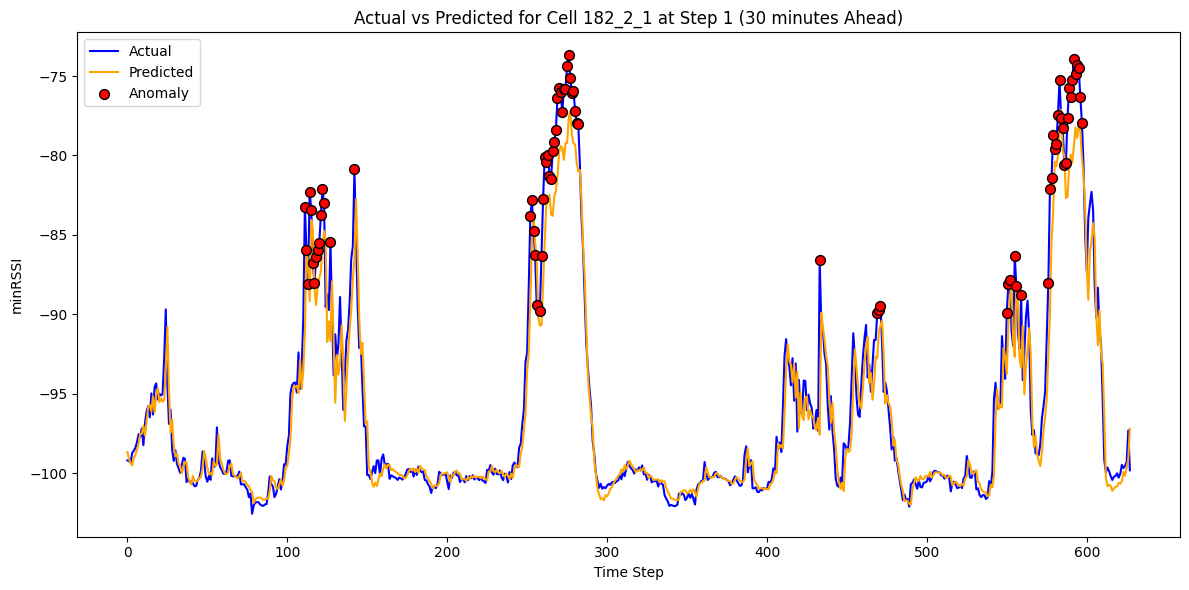

In [ ]:
sel_cell = '182_2_1'

plot_predictions(exp_folder + f'test_preds_{model_name}.csv', sel_cell, 1)

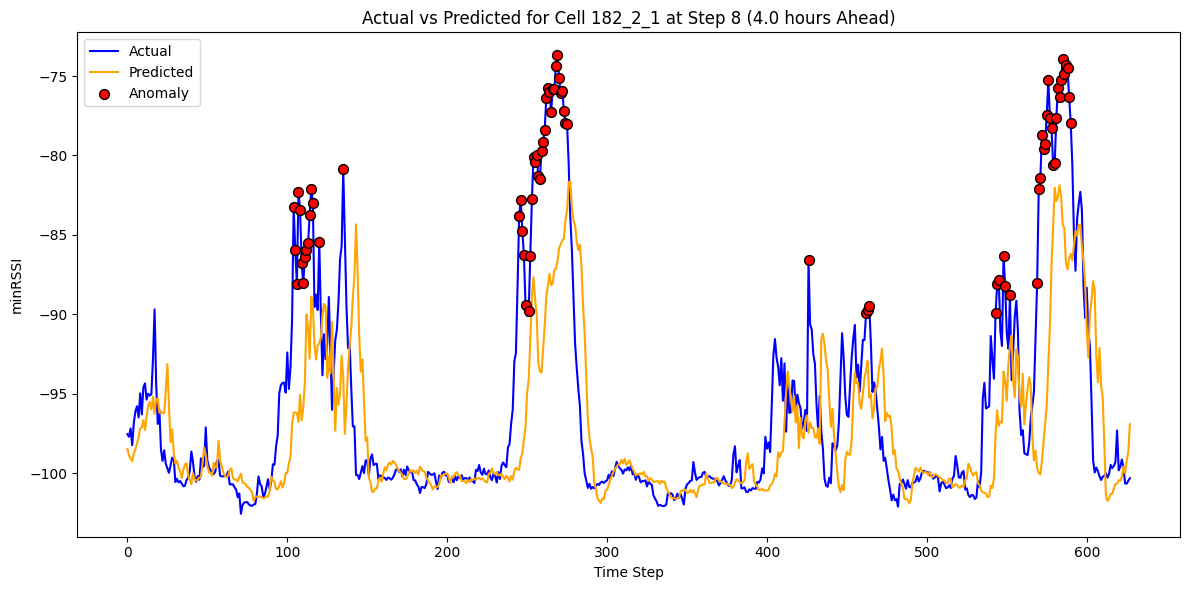

In [ ]:
plot_predictions(exp_folder + f'test_preds_{model_name}.csv', sel_cell, 8)

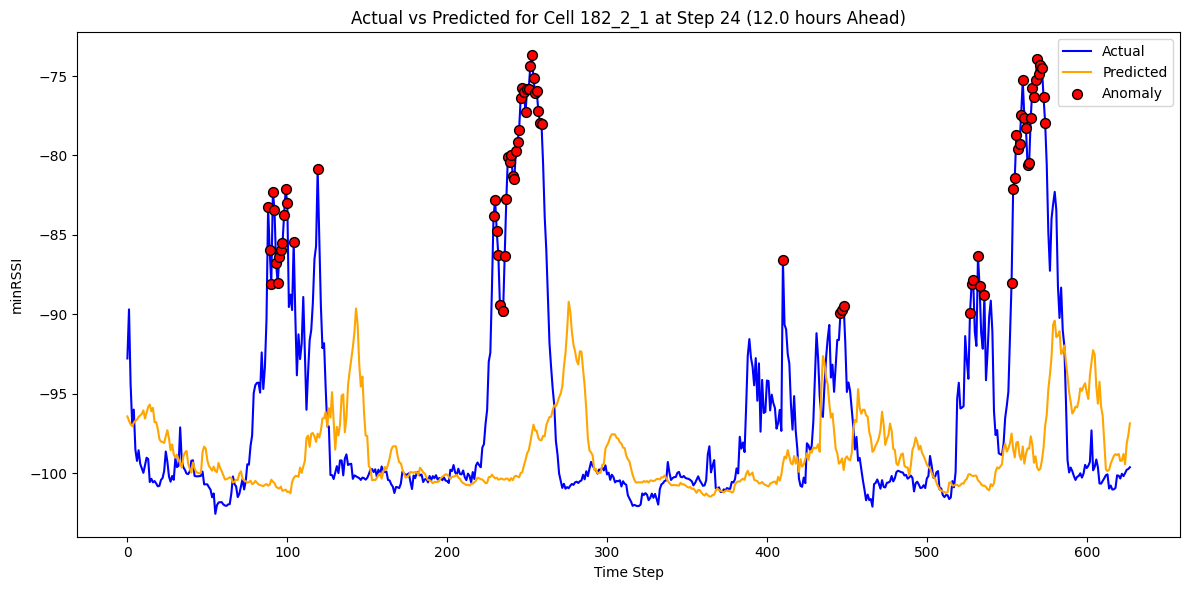

In [ ]:
plot_predictions(exp_folder + f'test_preds_{model_name}.csv', sel_cell, 24)